In [1]:
import picos as pc
import qics as qc
from qics.cones import OpPerspecEpi
import numpy as np
from sympy.matrices import Matrix
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
class Basis:
    def __init__(self, ops: list[str]):
        self._ops = ops
        self._mapping = {op: i for i, op in enumerate(ops)}
        self._sz = len(ops)
    
    def rank(self, word: str):
        v = self._sz ** (len(word)) - 1
        for i, op in enumerate(reversed(word)):
            v += self._mapping[op] * (self._sz ** i)
        return v

    def unrank(self, pos: int):
        len = 0
        while self._sz ** len - 1 <= pos:
            len += 1
        len -= 1
        pos -= self._sz ** len - 1
        word = [None] * len
        for i in range(len):
            word[i] = self._ops[pos % self._sz]
            pos //= self._sz
        return ''.join(word[::-1])

def commutator(word1: str, word2: str):
    expression = Counter()
    for i in range(len(word1)):
        for j in range(len(word2)):
            # 1 2 2 1
            word = word1[:i] + word2[:j] + word2[j+1:] + word1[i+1:]
            if word1[i] == 'x' and word2[j] == 'p':
                expression[word] += 1j
            elif word1[i] == 'p' and word2[j] == 'x':
                expression[word] -= 1j
    return expression

In [ ]:
def canonical_relation(x, basis, word1: str, word2: str):
    t1 = word1 + 'xp' + word2
    t2 = word1 + 'px' + word2
    t3 = word1 + word2
    return x[basis.rank(t1)] - x[basis.rank(t2)] == 1j * x[basis.rank(t3)]

def schwinger_dyson(x, basis, hamil: list, word1: str):
    expression = Counter()
    constraint = 0
    for coeff, w in hamil:
        expression.update(commutator(w, word1))
    for word, coeff in expression.items():
        constraint += coeff * x[basis.rank(word)]
    return constraint == 0

def normalization(x):
    return x[0] == 1

def reality(x, basis: Basis, word: str):
    return x[basis.rank(word[::-1])] == x.conj[basis.rank(word)]

def kms(basis, x, hamil, A, B, C, n2):
    constraints = []
    def get_A_term(i, j):
        return x[basis.rank(basis.unrank(i)[::-1] + basis.unrank(j))]
    def get_B_term(i, j):
        return x[basis.rank(basis.unrank(j) + basis.unrank(i)[::-1])]
    def get_C_term(i, j):
        expression = Counter()
        constraint = 0
        for coeff, w in hamil:
            expression.update(commutator(w, basis.unrank(j)))
        for word, coeff in expression.items():
            constraint += coeff * x[basis.rank(basis.unrank(i)[::-1] + word)]
        return constraint
    for i in range(n2):
        for j in range(i, n2):
            constraints.extend([A[i, j] == get_A_term(i, j), B[i, j] == get_B_term(i, j), C[i, j] == get_C_term(i, j)])
    return constraints

In [ ]:
def create_problem(L, hamil):
    basis = Basis(['x', 'p'])
    Pmin = pc.Problem('Energy lower bound')
    Pmax = pc.Problem('Energy upper bound')
    n = 2 ** (L + 1) - 1
    x = pc.ComplexVariable('op', (n, 1))
    d = 0
    H = 0
    for coeff, word in hamil:
        d = max(d, len(word))
        H += coeff * x[basis.rank(word)]
    Pmin.set_objective("min", H.real)
    Pmax.set_objective("max", H.real)
    n2 = 2 ** ((L - d + 2) // 2 + 1) - 1
    A = pc.HermitianVariable('A', n2)
    B = pc.HermitianVariable('B', n2)
    C = pc.HermitianVariable('C', n2)
    # KMS condition
    constraints = []
    constraints.extend(kms(basis, x, hamil, A, B, C, n2))
    # Normalization
    constraints.append(normalization(x))
    # Canonical relation
    n3 = 2 ** (L // 2) - 1
    for i in range(n3):
        for j in range(n3):
            constraints.append(canonical_relation(x, basis, basis.unrank(i), basis.unrank(j)))
    # Schwinger-Dyson
    n4 = 2 ** (L - d + 3) - 1
    for i in range(1, n4):
        constraints.append(schwinger_dyson(x, basis, hamil, basis.unrank(i)))
    # Reality
    for i in range(1, n):
        constraints.append(reality(x, basis, basis.unrank(i)))
    Pmin.add_list_of_constraints(constraints)
    Pmax.add_list_of_constraints(constraints)
    return Pmin, Pmax, A, B, C

def solve(L, betas, hamil, verbose=True):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    Pmin, Pmax, A, B, C = create_problem(L, hamil)
    KMS = betas[0] * C >> pc.oprelentr(A, B)
    Pmin.add_constraint(KMS)
    Pmax.add_constraint(KMS)
    for i, beta in enumerate(betas):
        if verbose:
            print(f'Solving for T={1/beta}, i={i}:')
        Pmin.solve(solver="qics")
        Pmax.solve(solver="qics")
        E_min = Pmin.value
        E_max = Pmax.value
        if verbose:
            print(f'\tE_min = {E_min}')
            print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
        if i + 1 < len(betas):
            Pmin.remove_constraint(KMS)
            Pmax.remove_constraint(KMS)
            KMS = betas[i + 1] * C >> pc.oprelentr(A, B)
            Pmin.add_constraint(KMS)
            Pmax.add_constraint(KMS)
    return mins, maxs


In [79]:
hamil = [(1, 'pp'), (1, 'xx')]
betas = 1 / np.linspace(0.1, 0.6, num=40)
L = 3
mins, maxs = solve(L, betas, hamil)

Solving for T=0.1, i=0:


/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/picos/expressions/exp_oprelentr.py:140: RuntimeWarning: invalid value encountered in sqrt
  rtX = Ux @ numpy.diag(numpy.sqrt(Dx)) @ Ux.conj().T


	E_min = 1.0000000566178742
	E_max = 1.0000000566178742
Solving for T=0.11282051282051282, i=1:
	E_min = 1.000000095489406
	E_max = 1.000000095489406
Solving for T=0.12564102564102564, i=2:
	E_min = 1.0000002653248286
	E_max = 1.0000002653248286
Solving for T=0.13846153846153847, i=3:
	E_min = 1.0000010935289656
	E_max = 1.0000010935289656
Solving for T=0.1512820512820513, i=4:
	E_min = 1.0000036606002443
	E_max = 1.0000036606002443
Solving for T=0.1641025641025641, i=5:
	E_min = 1.0000102090793117
	E_max = 1.0000102090793117
Solving for T=0.17692307692307693, i=6:
	E_min = 1.0000246830451618
	E_max = 1.0000246830451618
Solving for T=0.18974358974358974, i=7:
	E_min = 1.0000529255928559
	E_max = 1.0000529255928559
Solving for T=0.20256410256410257, i=8:
	E_min = 1.0001031614998357
	E_max = 1.0001031614998357
Solving for T=0.2153846153846154, i=9:
	E_min = 1.000185497559536
	E_max = 1.000185497559536
Solving for T=0.22820512820512817, i=10:
	E_min = 1.0003125515890923
	E_max = 1.0003125

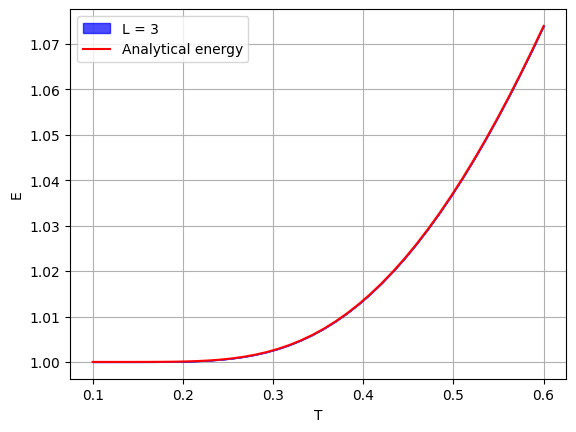

In [67]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.7, color='blue', label=f'L = {L}', zorder=2)
plt.plot(1/betas, 1/np.tanh(betas),c='red',label='Analytical energy',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.grid(zorder=1)
plt.legend()
plt.show()

<h2>Directly in QICS:</h2>

In [14]:
from mpmath import mp

In [21]:
mp.prec = 200
print(mp)

Mpmath settings:
  mp.prec = 200               [default: 53]
  mp.dps = 59                 [default: 15]
  mp.trap_complex = False     [default: False]


In [22]:
class BasisReduction():
    def __init__(self, A, b):
        self._A = A.copy()
        self._b = b.copy()
        self._Arref, self._brref = Matrix(A).rref_rhs(Matrix(b))
        self._pivots = Matrix(A).rref()[1]
        self._free = sorted(list(set(range(A.shape[1])) - set(self._pivots))) # This is with the original numbering
        self._sz = len(self._free)
        self._reductions = [[Counter(), 0.0] for _ in range(A.shape[1])]
        self._init_free() # Initialize mappings for free variables
        self._generate_reductions() # Initialize mappings for pivot variables

    def _init_free(self):
        for i, p in enumerate(self._free):
            self._reductions[p][0][i] += mp.mpf('1')
            self._reductions[p][1] = mp.mpf('0')
    
    def _generate_reductions(self):
        crow = len(self._pivots) - 1
        for pcol in reversed(self._pivots):
            # Create mapping
            self._reductions[pcol][1] += self._brref[crow]
            for ccol in range(pcol + 1, self._A.shape[1]):
                if not np.isclose(self._Arref[crow, ccol], 0.0):
                    coeff = -self._Arref[crow, ccol] # minus sign to transfer to other side of equality
                    self._reductions[pcol][1] += coeff * self._reductions[ccol][1]
                    for freew, c in self._reductions[ccol][0].items():
                        self._reductions[pcol][0][freew] += coeff * c
            # Update currow
            crow -= 1

    def size(self):
        return self._sz

    def reduce(self, p):
        # Return a mapping of the p-th element of the original basis
        # to a linear combination + constant offset of the new basis
        # Remember to take care of the numbering
        return self._reductions[p]

In [23]:
def canonical_relation(n, basis, word1: str, word2: str):
    b = np.zeros((2, 1))
    ur = np.zeros((1, 2 * n))
    uc = np.zeros((1, 2 * n))
    t1 = word1 + 'xp' + word2
    t2 = word1 + 'px' + word2
    t3 = word1 + word2
    p1 = basis.rank(t1)
    p2 = basis.rank(t2)
    p3 = basis.rank(t3)
    ur[0, 2 * p1] += 1
    uc[0, 2 * p1 + 1] += 1
    ur[0, 2 * p2] -= 1
    uc[0, 2 * p2 + 1] -= 1
    # if p3 == 0:
    #     b[1, 0] += 1
    # else:
    ur[0, 2 * p3 + 1] += 1
    uc[0, 2 * p3] -= 1
    return np.vstack([ur, uc]), b

def schwinger_dyson(n, basis, hamil: list, word1: str):
    b = np.zeros((2, 1))
    ur = np.zeros((1, 2 * n))
    uc = np.zeros((1, 2 * n))
    expression = Counter()
    for coeff, w in hamil:
        termsd = commutator(w, word1)
        for word, c in termsd.items():
            expression[word] += coeff * c
    for word, coeff in expression.items():
        p = basis.rank(word)
        # if p == 0:
        #     b[0, 0] -= np.real(coeff)
        #     b[1, 0] -= np.imag(coeff)
        # else:
        ur[0, 2 * p] += np.real(coeff)
        ur[0, 2 * p + 1] -= np.imag(coeff)
        uc[0, 2 * p] += np.imag(coeff)
        uc[0, 2 * p + 1] += np.real(coeff)
    return np.vstack([ur, uc]), b

def reality(n, basis: Basis, word: str):
    # We would never pass word = '' to this function anyway
    assert(word != '')
    b = np.zeros((2, 1))
    ur = np.zeros((1, 2 * n))
    uc = np.zeros((1, 2 * n))
    p1 = basis.rank(word[::-1])
    p2 = basis.rank(word)
    # real
    ur[0, 2 * p1] += 1
    ur[0, 2 * p2] -= 1
    # imag
    uc[0, 2 * p1 + 1] += 1
    uc[0, 2 * p2 + 1] += 1
    return np.vstack([ur, uc]), b

def normalization(n):
    b = np.zeros((2, 1))
    ur = np.zeros((1, 2 * n))
    uc = np.zeros((1, 2 * n))
    ur[0, 0] += 1
    uc[0, 1] += 1
    b[0, 0] += 1
    return np.vstack([ur, uc]), b

def get_A_term(basis, i, j):
    return basis.rank(basis.unrank(i)[::-1] + basis.unrank(j))
def get_B_term(basis, i, j):
    return basis.rank(basis.unrank(j) + basis.unrank(i)[::-1])
def get_C_term(basis, i, j, hamil):
    expression = Counter()
    termsd = Counter()
    for coeff, w in hamil:
        terms = commutator(w, basis.unrank(j))
        for word, c in terms.items():
            expression[word] += coeff * c
    for word, coeff in expression.items():
        termsd[basis.rank(basis.unrank(i)[::-1] + word)] += coeff
    return termsd

In [31]:
def construct_lin(n, d, basis, hamil):
    # We will build normalization directly into the constraints
    cons = []
    b = []
    # Normalization
    u, v = normalization(n)
    cons.append(u)
    b.append(v)
    # Canonical relation
    n3 = 2 ** (L // 2) - 1
    for i in range(n3):
        for j in range(n3):
            u, v = canonical_relation(n, basis, basis.unrank(i), basis.unrank(j))
            cons.append(u)
            b.append(v)
    # Schwinger-Dyson
    n4 = 2 ** (L - d + 3) - 1
    for i in range(1, n4):
        u, v = schwinger_dyson(n, basis, hamil, basis.unrank(i))
        cons.append(u)
        b.append(v)
    # Reality
    for i in range(1, n):
        u, v = reality(n, basis, basis.unrank(i))
        cons.append(u)
        b.append(v)
    A = np.vstack(cons)
    bv = np.vstack(b)
    return A, bv

def construct_cone(redbas, n2, basis, hamil):
    # Construct beta * C, A, B, in that order, noting splitting and vectorization
    # Separate out the beta * C part and the A, B part so that later we just do
    # np.vstack([beta * G_betaC, G_AB])
    n = redbas.size()
    G_betaC = mp.zeros(2 * n2 * n2, n)
    G_A = mp.zeros(2 * n2 * n2, n)
    G_B = mp.zeros(2 * n2 * n2, n)
    hA = mp.zeros(2 * n2 * n2, 1)
    hB = mp.zeros(2 * n2 * n2, 1)
    hC = mp.zeros(2 * n2 * n2, 1)
    for i in range(n2):
        for j in range(n2):
            # G_A
            p = get_A_term(basis, i, j)
            # if p == 0:
            #     hA[2 * n2 * i + 2 * j, 0] += 1
            # else:
            rew, const = redbas.reduce(2 * p)
            hA[2 * n2 * i + 2 * j, 0] += const
            for freew, c in rew.items():
                G_A[2 * n2 * i + 2 * j, freew] += c
            rew, const = redbas.reduce(2 * p + 1)
            hA[2 * n2 * i + 2 * j + 1, 0] += const
            for freew, c in rew.items():
                G_A[2 * n2 * i + 2 * j + 1, freew] += c
            # G_B
            p = get_B_term(basis, i, j)
            # if p == 0:
            #     hB[2 * n2 * i + 2 * j, 0] += 1
            # else:
            rew, const = redbas.reduce(2 * p)
            hB[2 * n2 * i + 2 * j, 0] += const
            for freew, c in rew.items():
                G_B[2 * n2 * i + 2 * j, freew] += c
            rew, const = redbas.reduce(2 * p + 1)
            hB[2 * n2 * i + 2 * j + 1, 0] += const
            for freew, c in rew.items():
                G_B[2 * n2 * i + 2 * j + 1, freew] += c
            termsd = get_C_term(basis, i, j, hamil)
            for p, c in termsd.items():
                # if p == 0:
                #     hC[2 * n2 * i + 2 * j, 0] += np.real(c)
                #     hC[2 * n2 * i + 2 * j + 1, 0] += np.imag(c)
                # else:
                rewr, constr = redbas.reduce(2 * p)
                rewc, constc = redbas.reduce(2 * p + 1)
                cr, cc = np.real(c), np.imag(c)
                # So complicated...
                # G[i, j] = sum over (cr + i cc) * (word[2p] + i word[2p+1])
                # G[i, j]r = sum over cr word[2p] - cc word[2p+1]
                # G[i, j]c = sum over cc word[2p] + cr word[2p+1]
                # G[i, j]r
                hC[2 * n2 * i + 2 * j, 0] += cr * constr - cc * constc
                for p, c in rewr.items():
                    G_betaC[2 * n2 * i + 2 * j, p] += cr * c
                for p, c in rewc.items():
                    G_betaC[2 * n2 * i + 2 * j, p] -= cc * c
                # G[i, j]c
                hC[2 * n2 * i + 2 * j + 1, 0] += cc * constr + cr * constc
                for p, c in rewr.items():
                    G_betaC[2 * n2 * i + 2 * j + 1, p] += cc * c
                for p, c in rewc.items():
                    G_betaC[2 * n2 * i + 2 * j + 1, p] += cr * c
    return G_betaC, np.vstack([G_A, G_B]), hC, np.vstack([hA, hB])

def create_problem(L, hamil):
    # print(hamil)
    basis = Basis(['x', 'p'])
    n = 2 ** (L + 1) - 1
    d = 0
    for coeff, word in hamil:
        d = max(d, len(word))
    n2 = 2 ** ((L - d + 2) // 2 + 1) - 1
    A, b = construct_lin(n, d, basis, hamil)
    # Now we solve Ax=b to rewrite stuff in terms of free variables
    redbas = BasisReduction(A, b)
    # And then we construct G and h accordingly
    G_betaC, G_AB, h_betaC, h_AB = construct_cone(redbas, n2, basis, hamil)
    # Also construct c
    c = mp.zeros(redbas.size(), 1)
    offset = 0
    for coeff, word in hamil:
        # rew will be a dict with mapping {rank in reduced basis: coefficient}
        p2 = basis.rank(word)
        rew, const = redbas.reduce(2 * p2) # Don't bother with the imaginary part, it doesn't appear
        offset += coeff * const
        for p, c2 in rew.items():
            c[p, 0] += coeff * c2
    cones = [OpPerspecEpi(n2, func="log", iscomplex=True)]
    return G_betaC, G_AB, h_betaC, h_AB, c, offset, cones

def solve(L, betas, hamil, verbose=True):
    mins, maxs = np.zeros_like(betas), np.zeros_like(betas)
    G_betaC, G_AB, h_betaC, h_AB, c, offset, cones = create_problem(L, hamil)
    for i, beta in enumerate(betas):
        if verbose:
            print(f'Solving for T={1/beta}, i={i}:')
        # Note the sign for G, since QICS requires h - Gx in K
        G = np.vstack([beta * G_betaC, G_AB])
        h = np.vstack([beta * h_betaC, h_AB])
        # G = np.vstack([G_betaC, G_AB / beta])
        # h = np.vstack([h_betaC, h_AB / beta])
        minmodel = qc.Model(c=c, G=-G, h=h, cones=cones, offset=offset)
        maxmodel = qc.Model(c=-c, G=-G, h=h, cones=cones, offset=-offset)
        minsolver = qc.Solver(minmodel, verbose=0)
        maxsolver = qc.Solver(maxmodel, verbose=0)
        mininfo = minsolver.solve()
        maxinfo = maxsolver.solve()
        E_min = mininfo['p_obj']
        E_max = -maxinfo['p_obj']
        if verbose:
            print(f'\tE_min = {E_min}')
            print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs


In [32]:
hamil = [(1, 'pp'), (1, 'xx')]
betas = np.array([1 / x for x in mp.linspace(mp.mpf('0.1'), mp.mpf('0.6'), 40)])
L = 3
mins, maxs = solve(L, betas, hamil)

Solving for T=0.1, i=0:


AttributeError: 'matrix' object has no attribute 'shape'

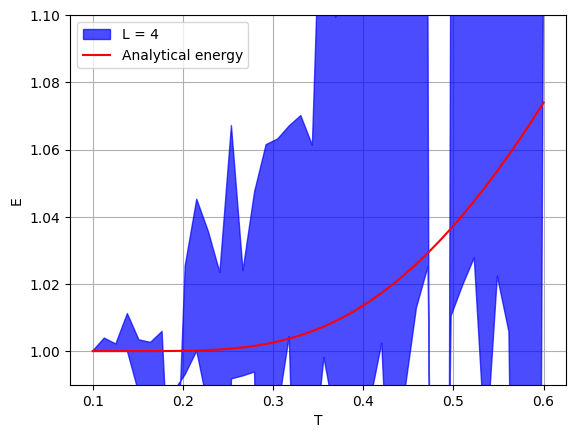

In [11]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.7, color='blue', label=f'L = {L}', zorder=2)
plt.plot(1/betas, 1/np.tanh(betas),c='red',label='Analytical energy',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.ylim(0.99, 1.1)
plt.grid(zorder=1)
plt.legend()
plt.show()

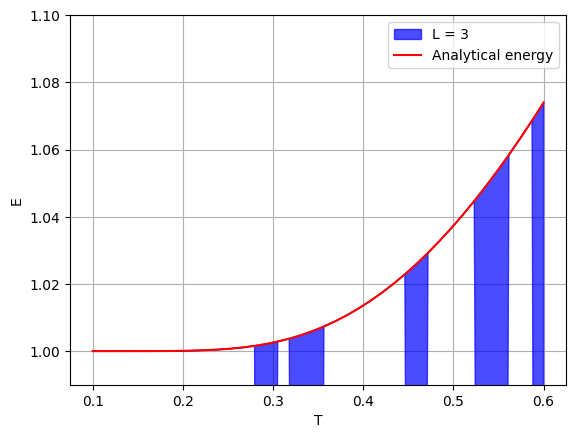

In [298]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.7, color='blue', label=f'L = {L}', zorder=2)
plt.plot(1/betas, 1/np.tanh(betas),c='red',label='Analytical energy',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.ylim(0.99, 1.1)
plt.grid(zorder=1)
plt.legend()
plt.show()

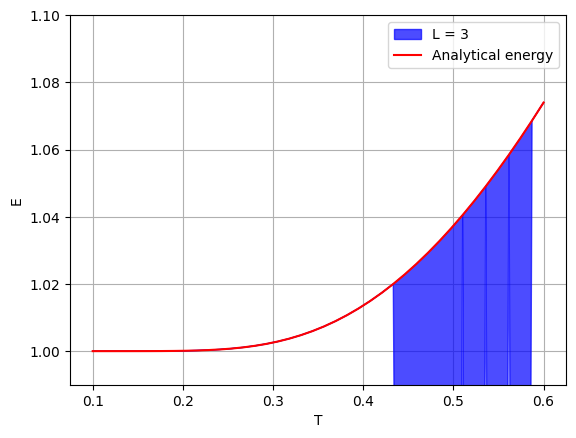

In [295]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.7, color='blue', label=f'L = {L}', zorder=2)
plt.plot(1/betas, 1/np.tanh(betas),c='red',label='Analytical energy',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.ylim(0.99, 1.1)
plt.grid(zorder=1)
plt.legend()
plt.show()